In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.svm import SVC


# Problem statement
1. Identify the key health parameters that influence the presence of cardiovascular disease in individuals.

2. Predict if a patient would have cadio vascular disease or not and Select most efficient model to predit if a patient has cadio vascular disease or not 

# Hypothesis
We hypothesize that age, blood pressure (both systolic and diastolic), and cholesterol levels are the most significant factors in determining the presence of cardiovascular disease.

Inorder to test the above hypothesis and predict if a patient has cadio-vascular disease or not, we would conduct exploratory data analysis. First, load the dataset, ascertain the total number of rows and columns in our dataset and check for missing values 

In [3]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/Pelumioluwa/MBAN6110Class/main/Data/cardio_train.csv', sep=';')

# Check the shape of the dataset
print('Shape of the dataset:', data.shape)

# Check for missing values
print('\nMissing values in the dataset:')
print(data.isnull().sum())



Shape of the dataset: (70000, 13)

Missing values in the dataset:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [4]:
# check for duplicate values
data.duplicated().sum()

0

The dataset contains 70,000 observations and 13 features. Here are some insights from the initial exploration and data definition for each column: There are no missing values in the dataset

id: Patient identification number

age: Patient's age in days

gender: Patient's gender, 1 woman, 2 men

height: Patient's height in cm

weight: Patient's weight in kg

ap_hi: Systolic blood pressure - when heart beats

ap_lo: Diastolic blood pressure - in between heart beats

cholesterol: Cholesterol level (1: normal, 2: above normal, 3: well above normal)

gluc: Glucose level (1: normal, 2: above normal, 3: well above normal)

smoke: Binary feature (0: doesn't smoke, 1: smokes)

alco: Binary feature (0: doesn't drink alcohol, 1: drinks alcohol)

active: Binary feature (0: not physically active, 1: physically active)

cardio: Presence or absence of cardiovascular disease (0: disease not present, 1: disease present)

Numerical variables: age, height, weight, ap_hi, ap_lo.

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio.

In [5]:
# Get summary statistics for all variables
print('\nSummary statistics for all variables:')
print(data.describe())


Summary statistics for all variables:
                 id           age        gender        height        weight   
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000  \
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke   
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000  \
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154

# The descriptive statistics for the numerical variables are as follows:

age: The average age is around 19468 days (which is roughly 53 years). The youngest person in the dataset is around 10798 days old (about 30 years), while the oldest is around 23713 days old (about 65 years).

height: The average height is approximately 164.36 cm. The shortest individual is 55 cm and the tallest is 250 cm. There might be some data entry errors as it's unlikely for an adult to be 55 cm tall.

weight: The average weight is about 74.21 kg. The lightest individual weighs 10 kg (which is likely a data entry error) and the heaviest weighs 200 kg.

ap_hi (Systolic blood pressure): The average is around 128.82. However, there are some suspicious values such as -150 and 16020 which are likely due to data entry errors.

ap_lo (Diastolic blood pressure): The average is around 96.63. Similar to ap_hi, there are some suspicious values such as -70 and 11000 which are likely due to data entry errors.

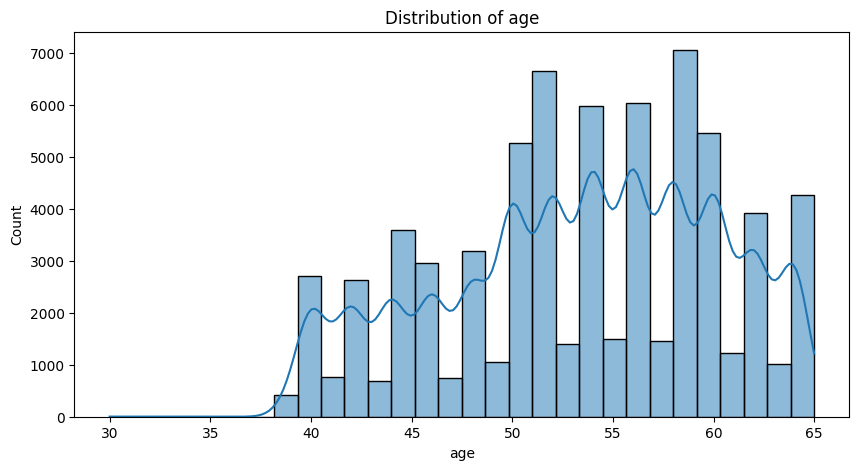

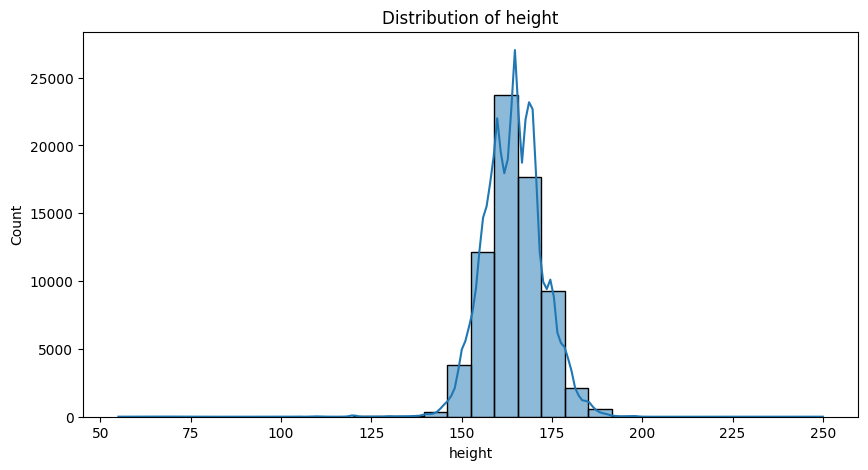

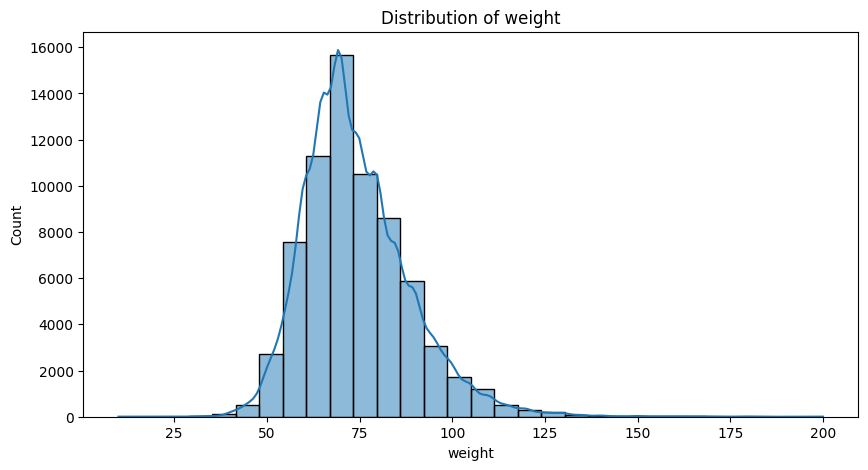

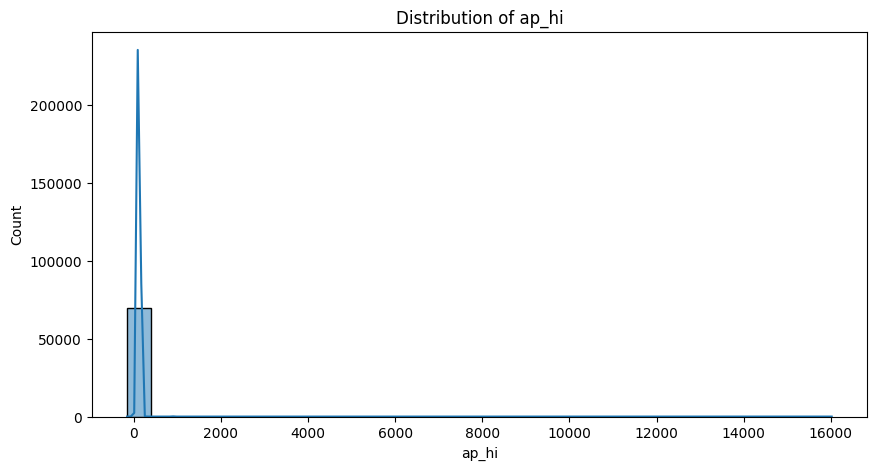

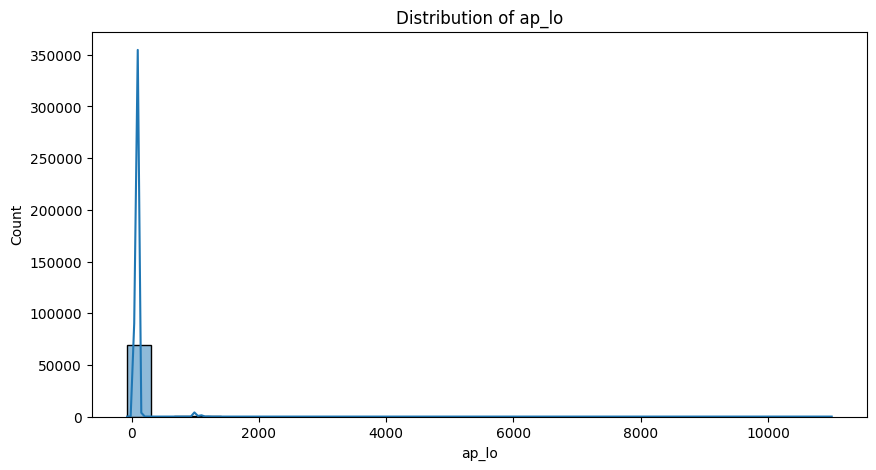

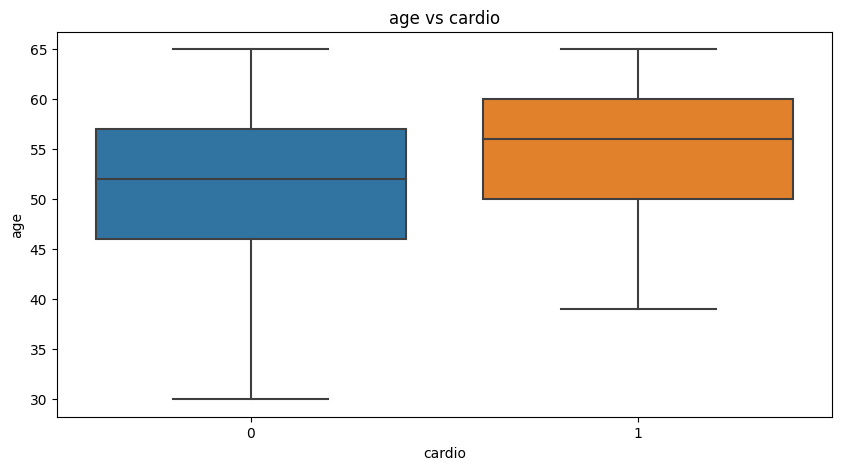

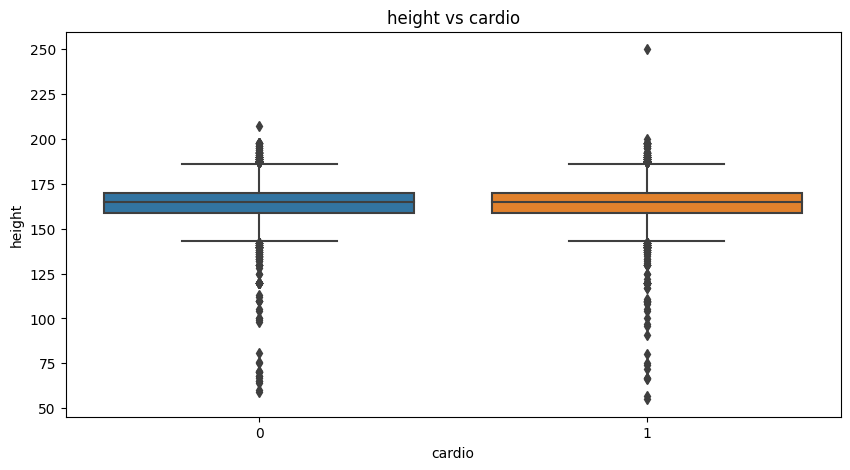

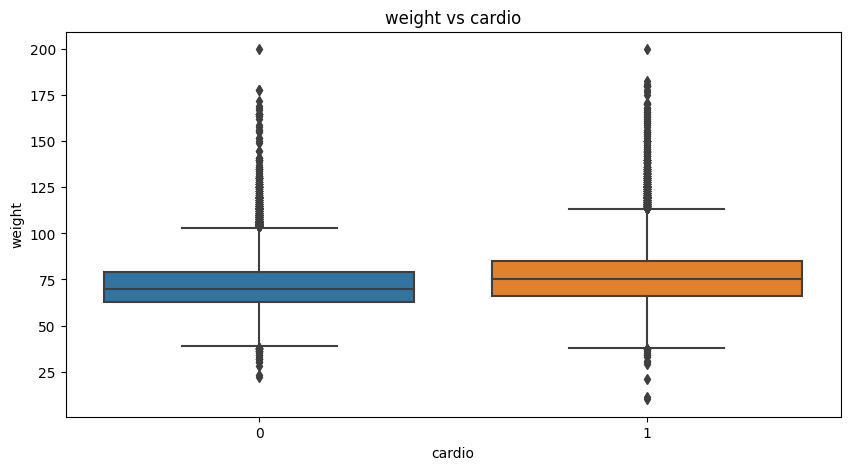

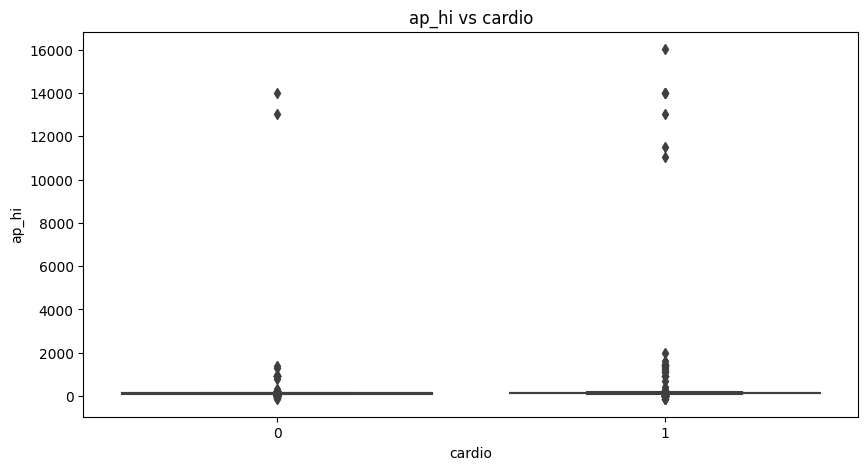

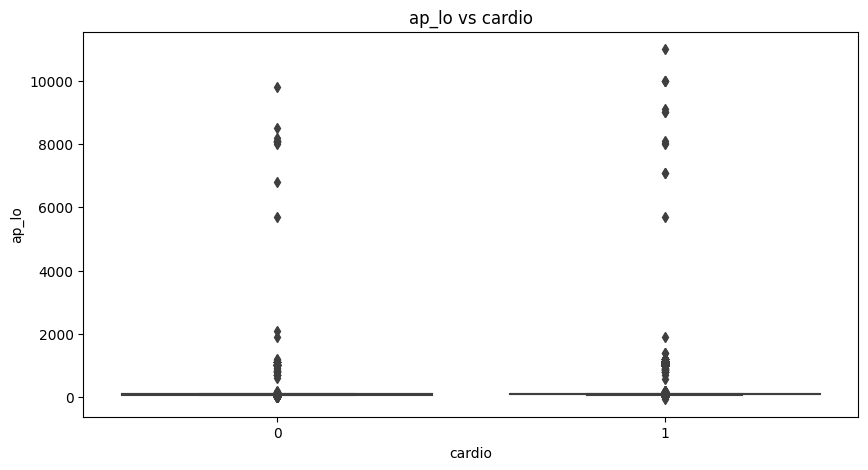

In [6]:
# Convert age from days around to years 
data['age'] = (data['age'] / 365) .round().astype('int')

# List of numerical columns
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Plot histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


# Plot boxplots of numerical columns against the target variable
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cardio', y=col, data=data)
    plt.title(f'{col} vs cardio')
    plt.show()

<Axes: xlabel='cardio', ylabel='Count'>

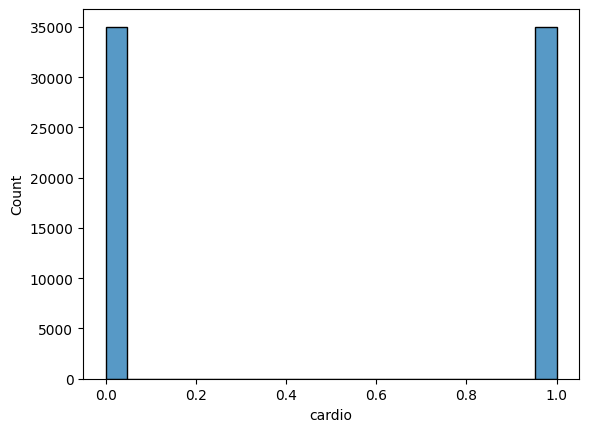

In [7]:
#distribution of cardio column
sns.histplot(data['cardio'])

## Orignial Data Analysis - numerical variables

Age: The distribution is slightly left-skewed. Most of the patients are in the age range of 40 to 65 years. The age of individuals with cardiovascular disease (cardio=1) is generally higher than those without the disease (cardio=0). 

Height: The distribution is roughly normal, with most heights ranging between 150 and 180 cm. There are some values at the lower end that could be considered outliers.  The median height is slightly lower for individuals with cardiovascular disease (cardio=1) compared to those without the disease (cardio=0). 

Weight: The distribution is slightly right-skewed, with most weights ranging between 50 and 100 kg.  
Individuals with cardiovascular disease (cardio=1) tend to have higher weight than those without the disease (cardio=0). 

ap_hi and ap_lo: These distributions are heavily affected by outliers, and it's hard to make out the true distributions.

Individuals with cardiovascular disease (cardio=1) tend to have higher systolic blood pressure (ap_hi) than those without the disease (cardio=0). 
Individuals with cardiovascular disease (cardio=1) tend to have higher diastolic blood pressure (ap_lo) than those without the disease (cardio=0).

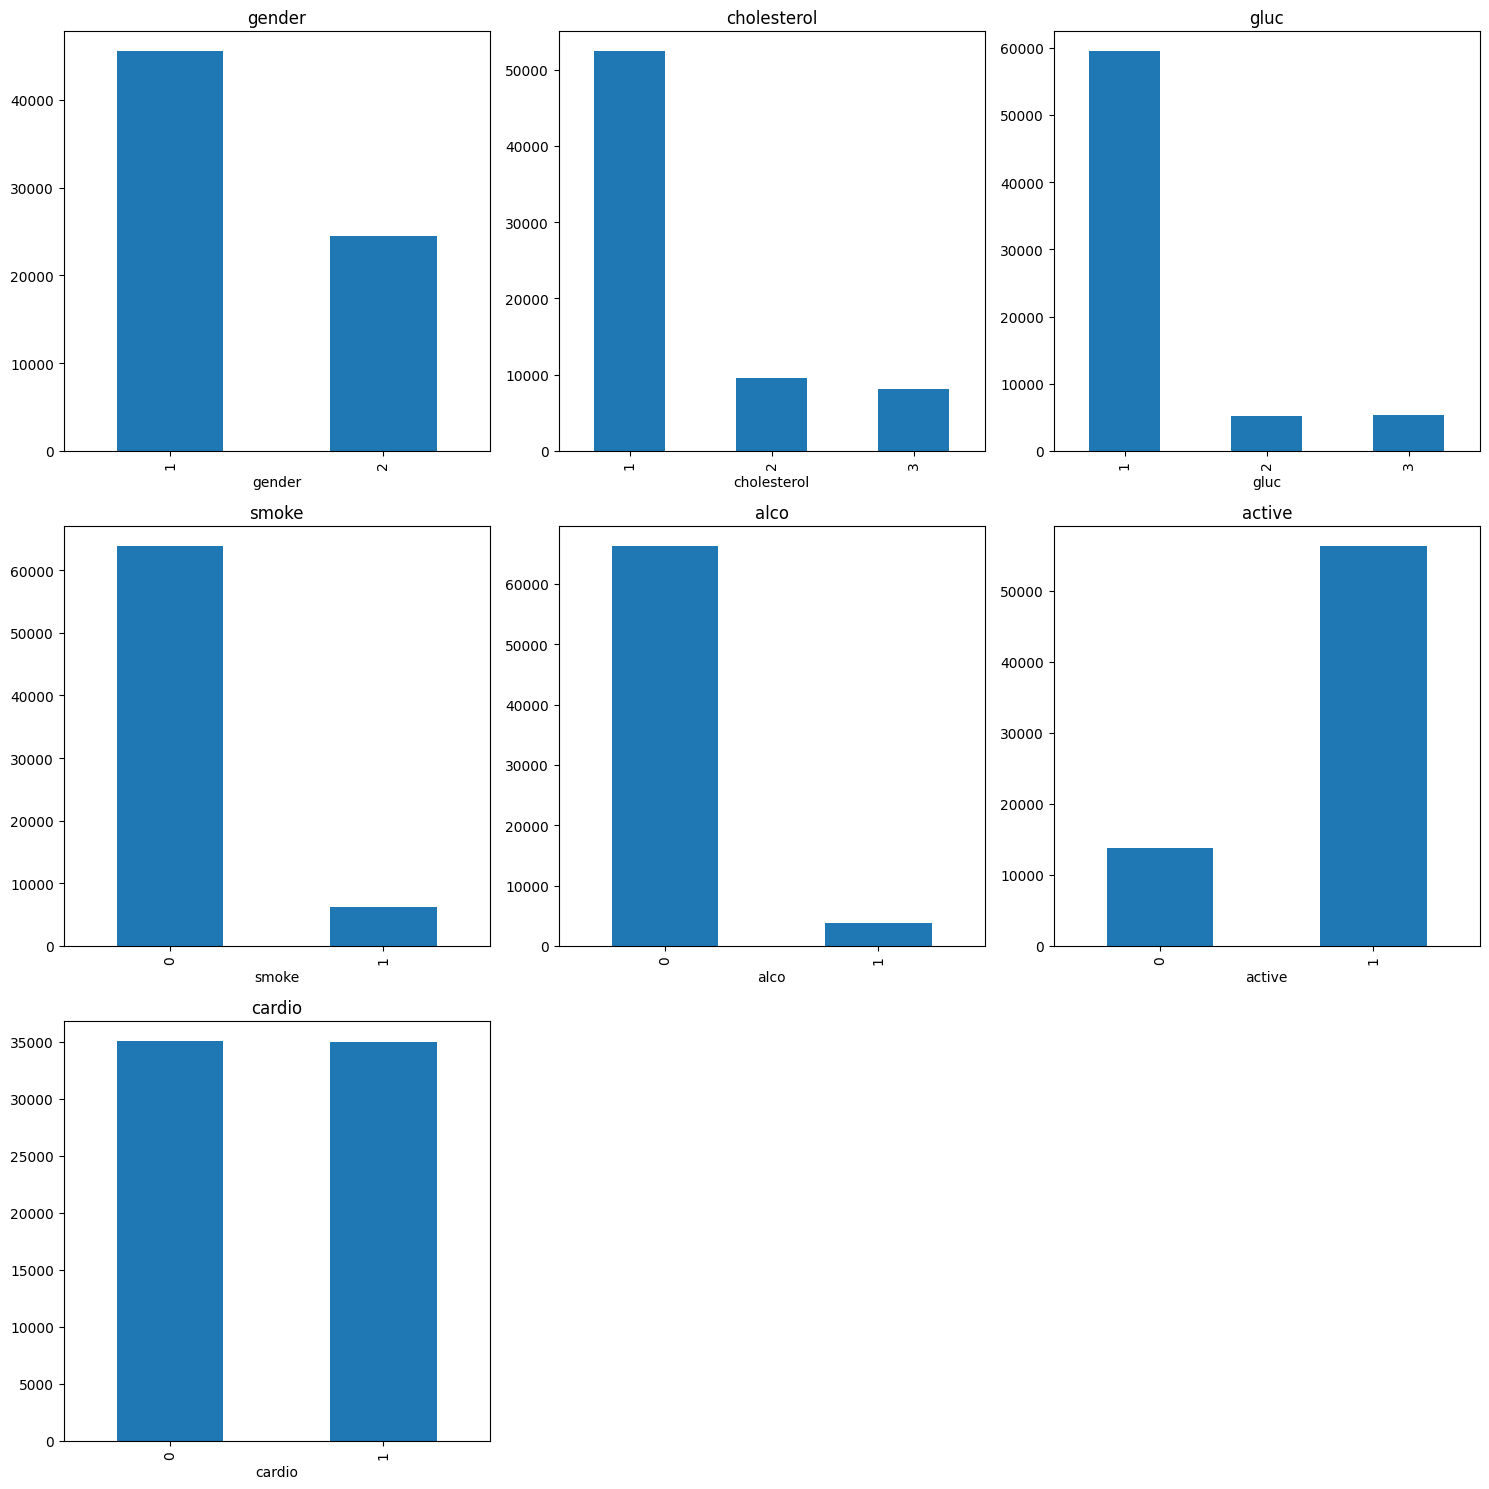

In [8]:
# Select categorical columns
categorical_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Create bar plots for each categorical column
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for column, ax in zip(categorical_columns, axs.flatten()):
    data[column].value_counts().sort_index().plot(kind='bar', ax=ax, title=column)

# Remove unused subplots
for ax in axs.flatten()[len(categorical_columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Original data analysis - categorical variables

Gender: There are more individuals of gender 1 (female) than gender 2 (male).

Cholesterol: Most individuals have a normal cholesterol level (1), but a significant number have above normal (2) and well above normal (3) levels.

Glucose (gluc): Similar to cholesterol, most individuals have a normal glucose level (1), but a significant number have above normal (2) and well above normal (3) levels.

Smoke: The majority of individuals in the dataset are non-smokers.

Alcohol (alco): The majority of individuals in the dataset do not consume alcohol.

Physical Activity (active): Most individuals in the dataset are physically active.

Cardiovascular Disease (cardio): The dataset is fairly balanced in terms of individuals with and without cardiovascular disease.

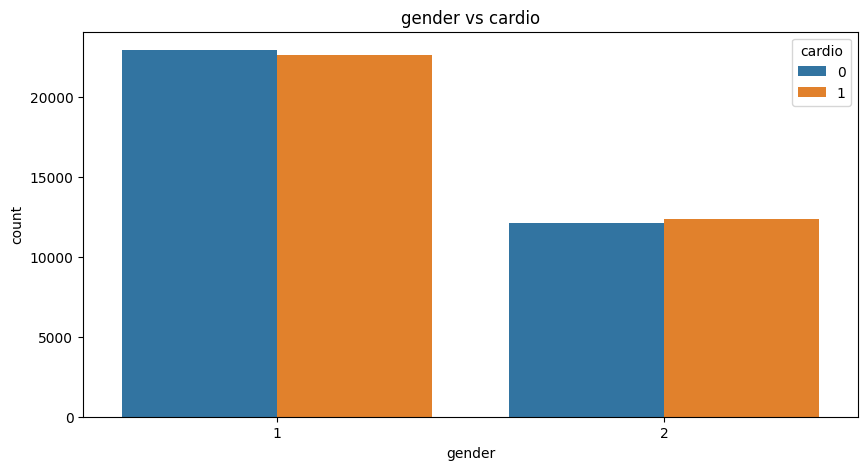

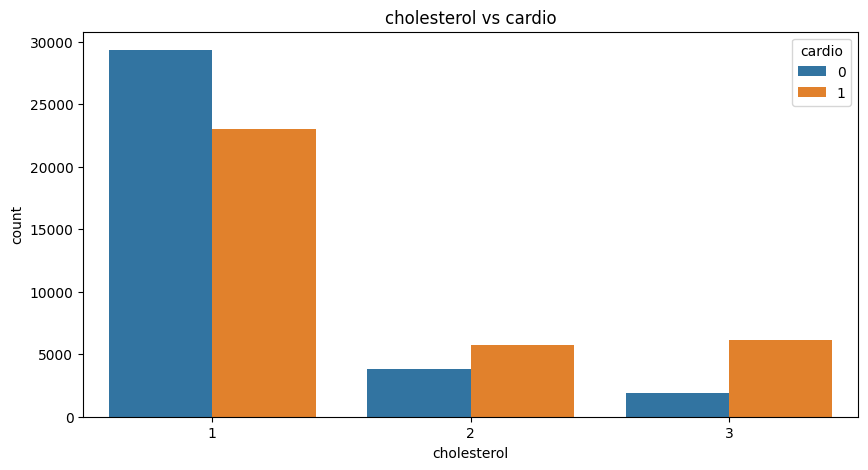

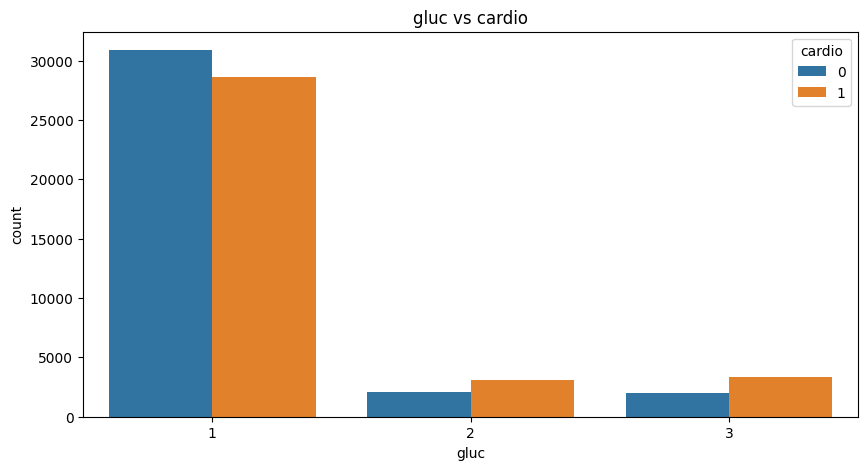

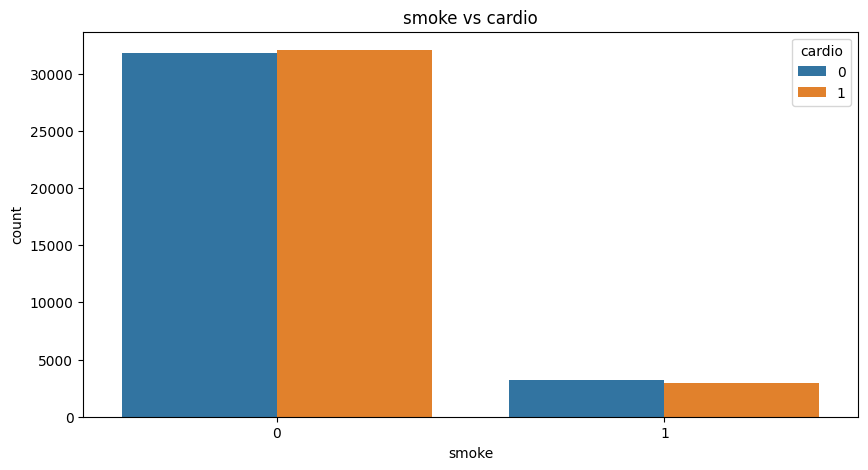

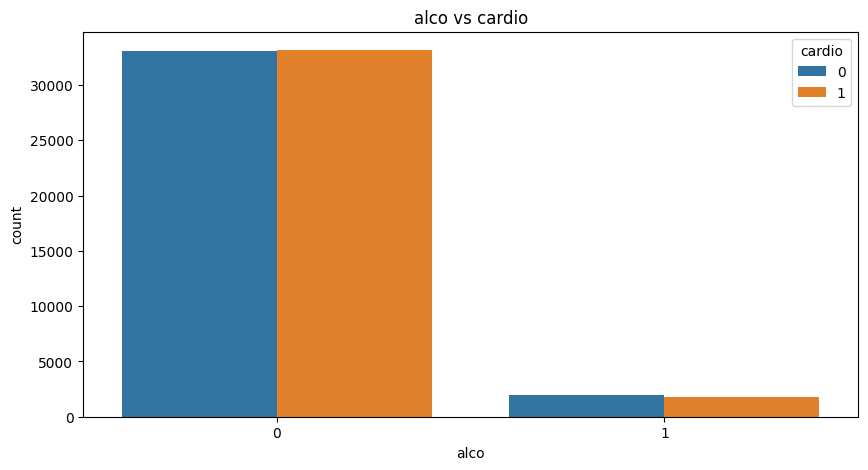

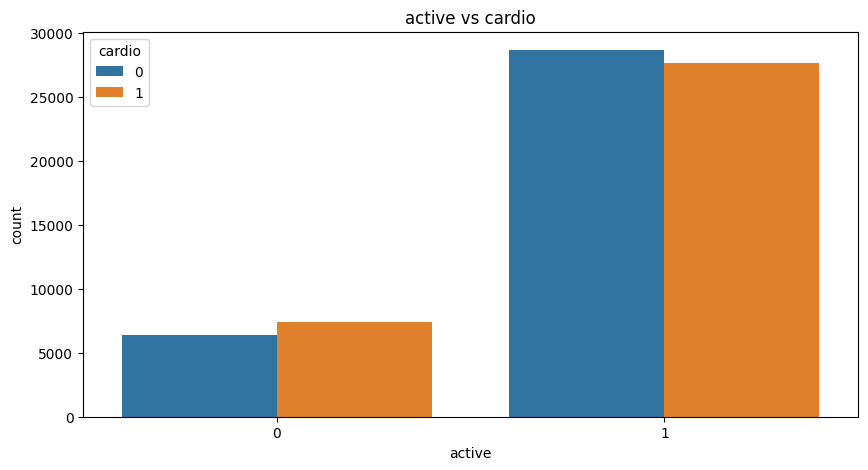

In [9]:
# List of categorical variables
cat_cols =['gender','cholesterol','gluc','smoke', 'alco','active']

# Plot countplots of categorical columns against the target variable
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='cardio', data= data)
    plt.title(f'{col} vs cardio')
    plt.show()

# Original categorical data vs. cardio(target variable)

Gender: There doesn't appear to be a significant difference in the prevalence of cardiovascular disease between the two genders.

Cholesterol: Individuals with above normal (2) and well above normal (3) cholesterol levels seem to have a higher prevalence of cardiovascular disease than those with normal levels (1).

Glucose (gluc): Similar to cholesterol, individuals with above normal (2) and well above normal (3) glucose levels seem to have a higher prevalence of cardiovascular disease than those with normal levels (1).

Smoke: There doesn't seem to be a significant difference in the prevalence of cardiovascular disease between smokers and non-smokers.

Alcohol (alco): There doesn't seem to be a significant difference in the prevalence of cardiovascular disease between those who consume alcohol and those who do not.

Physical Activity (active): Individuals who are not physically active seem to have a slightly higher prevalence of cardiovascular disease than those who are active.

These observations suggest that cholesterol and glucose levels may be associated with the prevalence of cardiovascular disease, while the other factors (gender, smoking status, alcohol consumption, and physical activity level) do not appear to have a strong association with the disease in this dataset.

In [10]:
# Since weight is a important factor for cardio, we create BMI to measure
# Create a BMI column
data['bmi'] = data['weight'] / (data['height'] / 100) ** 2

In [11]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50.472681
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


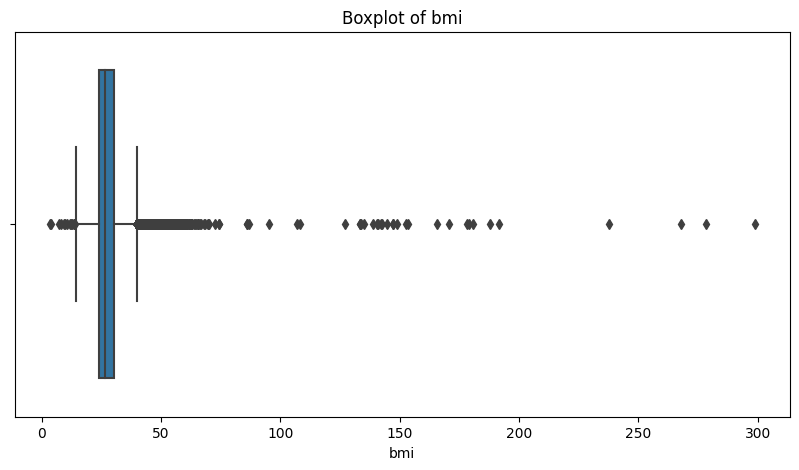

In [12]:
# Plot a boxplot for 'bmi'
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['bmi'])
plt.title('Boxplot of bmi')
plt.show()

## Data Cleaning - outliers

Age  range: 40 - 65


Height range : 100 cm - 220 cm 
Height has a minimum of 55 cm and a maximum of 250 cm. Heights below 100 cm or above 220 cm could be considered as outliers since these are quite uncommon values for adult human heights.

Wieght : 40kg  - 150kg 
weight has a minimum of 10 kg and a maximum of 200 kg. Weights below 40 kg or above 150 kg could be considered as outliers since these are quite uncommon values for adult human weights.

ap_hi and ap_lo : ap_hi 70 - 190 ; ap_lo 40 - 120 
contain some unrealistic values that we need to handle. Let's address these outliers next. We will consider systolic values (ap_hi) below 70 and above 190, and diastolic values (ap_lo) below 40 and above 120 as outliers and remove them from the dataset. These thresholds are set based on medical knowledge about typical blood pressure values.
reason to remove: they are likely to be errors and don't represent typical human blood pressure values.

BMI: 15 - 40. A BMI below 15 or above 40 is quite uncommon. A BMI below 15 is considered very severely underweight, while a BMI above 40 is considered very severely obese.

In [13]:
# Compute the IQR for 'age'
Q1_age = data['age'].quantile(0.25)
Q3_age = data['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

# Define the boundaries for outliers
lower_bound = Q1_age - 1.5 * IQR_age
upper_bound = Q3_age + 1.5 * IQR_age

# Identify the outliers
outliers_age = data[(data['age'] < lower_bound) | (data['age'] > upper_bound)]

# Display the outliers
outliers_age


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
6219,8850,30,1,175,59.0,120,80,1,1,0,0,1,0,19.265306
22343,31922,30,2,175,92.0,100,60,1,1,0,0,1,0,30.040816
30666,43842,30,1,159,59.0,120,80,1,1,0,0,1,0,23.337684
55905,79749,30,1,160,59.0,110,70,1,1,0,0,1,0,23.046875


In [14]:
# Copy the original dataset
data_copy = data.copy()

# Define the thresholds
height_thresholds = [100, 220]
weight_thresholds = [40, 150]
ap_hi_thresholds = [70, 190]
ap_lo_thresholds = [40, 120]
bmi_thresholds = [15, 40]

# Calculate the number of outliers for each variable
height_outliers = data_copy[(data_copy['height'] < height_thresholds[0]) | (data_copy['height'] > height_thresholds[1])].shape[0]
weight_outliers = data_copy[(data_copy['weight'] < weight_thresholds[0]) | (data_copy['weight'] > weight_thresholds[1])].shape[0]
ap_hi_outliers = data_copy[(data_copy['ap_hi'] < ap_hi_thresholds[0]) | (data_copy['ap_hi'] > ap_hi_thresholds[1])].shape[0]
ap_lo_outliers = data_copy[(data_copy['ap_lo'] < ap_lo_thresholds[0]) | (data_copy['ap_lo'] > ap_lo_thresholds[1])].shape[0]
bmi_outliers = data_copy[(data_copy['bmi'] < bmi_thresholds[0]) | (data_copy['bmi'] > bmi_thresholds[1])].shape[0]

# Print the number of outliers for each variable
height_outliers, weight_outliers, ap_hi_outliers, ap_lo_outliers, bmi_outliers


(30, 111, 409, 1115, 1899)

In [15]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [16]:
# Remove age outliers
data = data[(data['age'] >= lower_bound) & (data['age'] <= upper_bound)]

# Remove height outliers
data = data[(data['height'] >= 100) & (data['height'] <= 220)]

# Remove weight outliers
data = data[(data['weight'] >= 40) & (data['weight'] <= 150)]

# Remove blood pressure outliers
data = data[(data['ap_hi'] >= 70) & (data['ap_hi'] <= 190)]
data = data[(data['ap_lo'] >= 40) & (data['ap_lo'] <= 120)]

# Remove BMI outliers
data = data[(data['bmi'] >= 15) & (data['bmi'] <= 40)]

# Show the all rows of  cleaned data
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


The data is cleaned now.

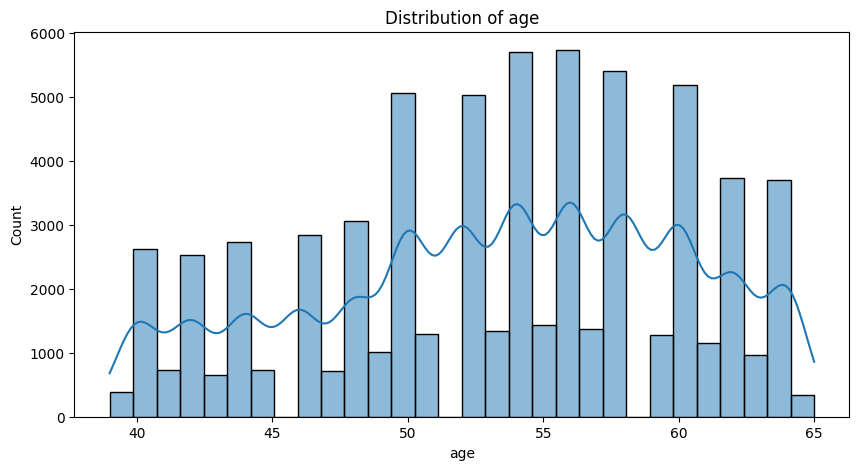

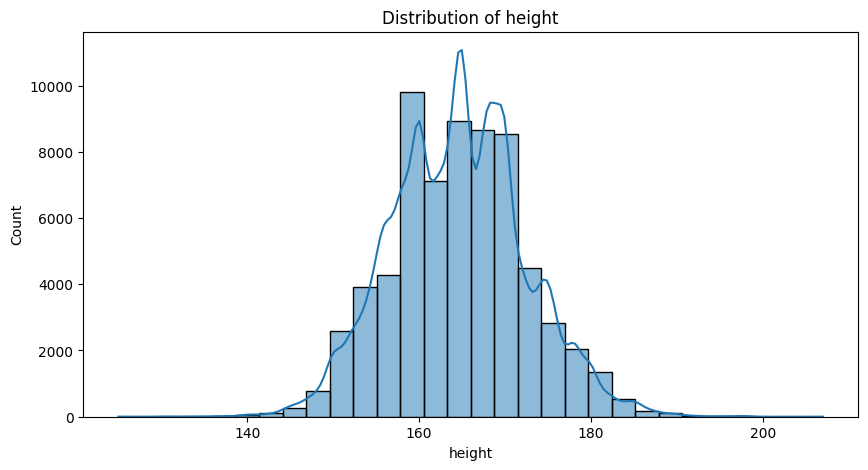

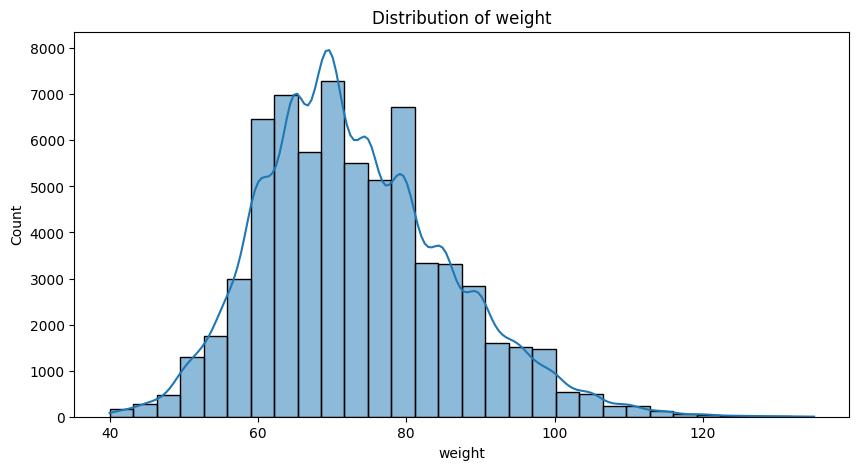

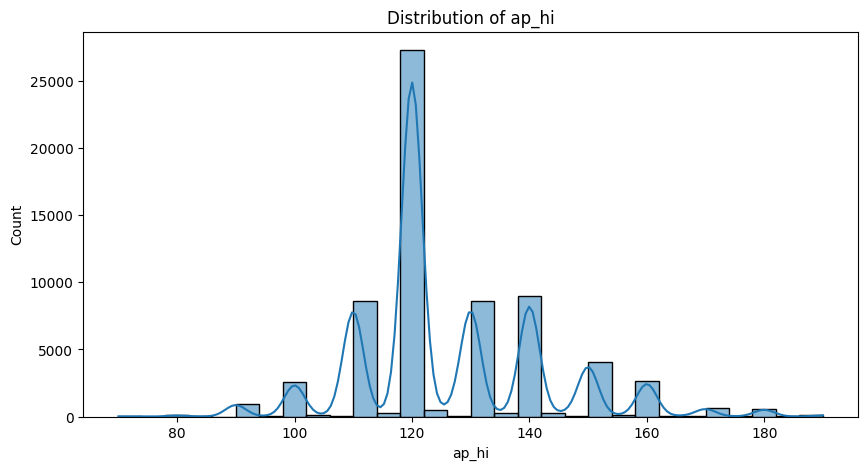

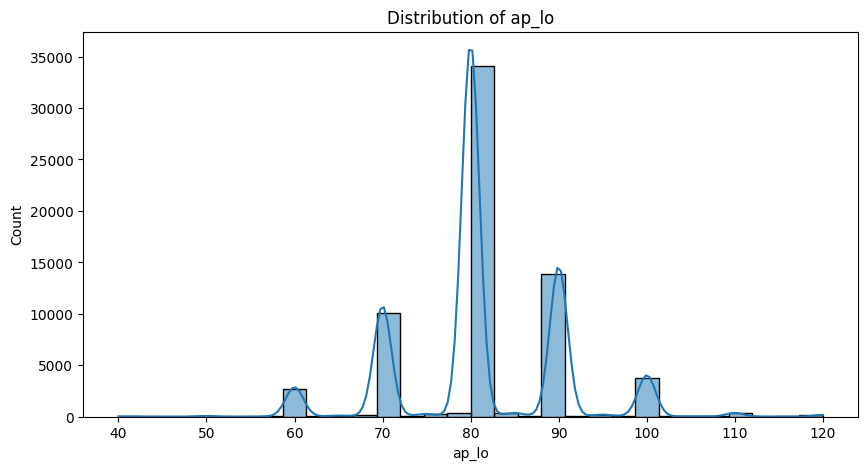

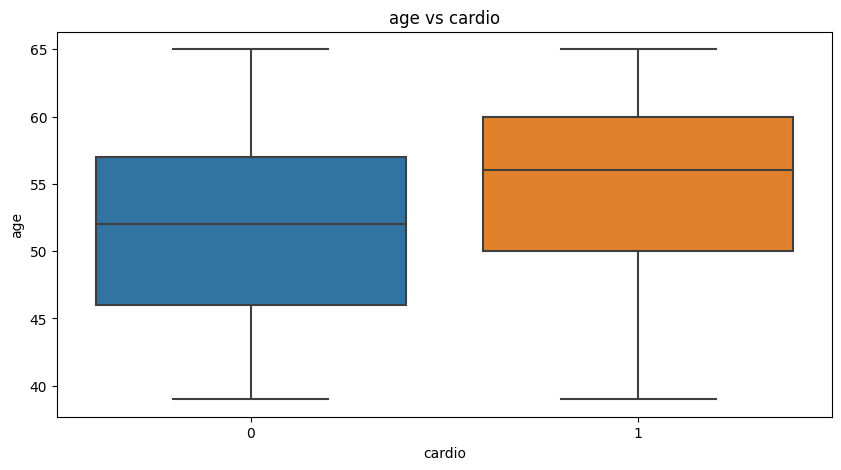

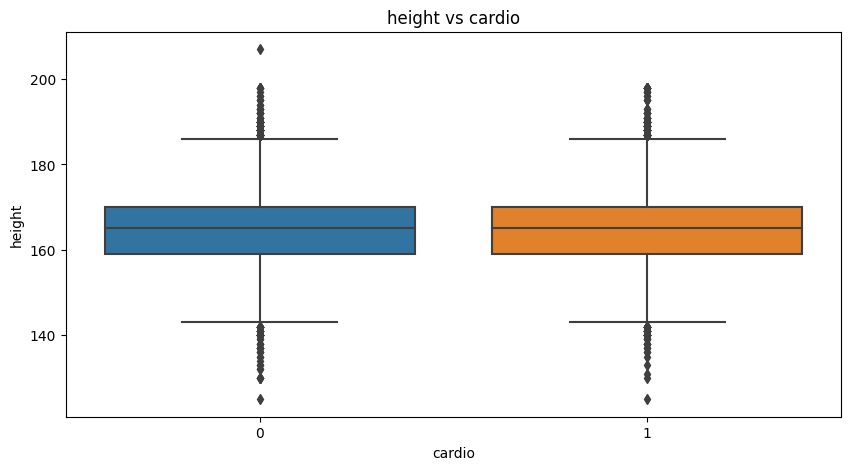

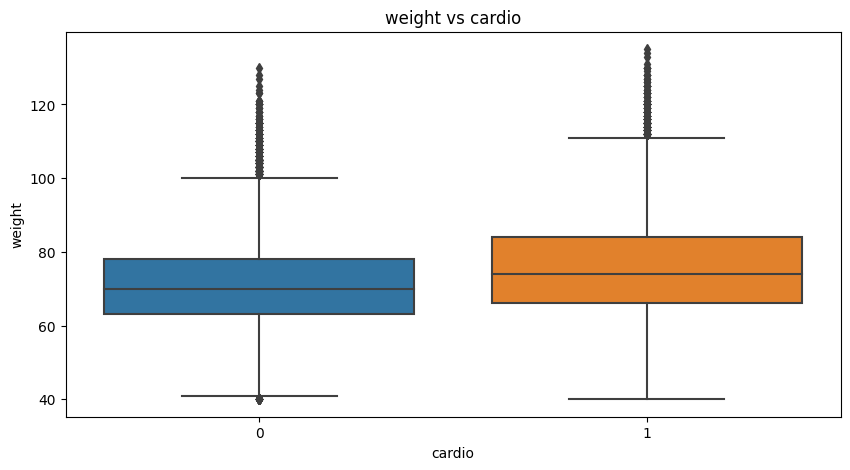

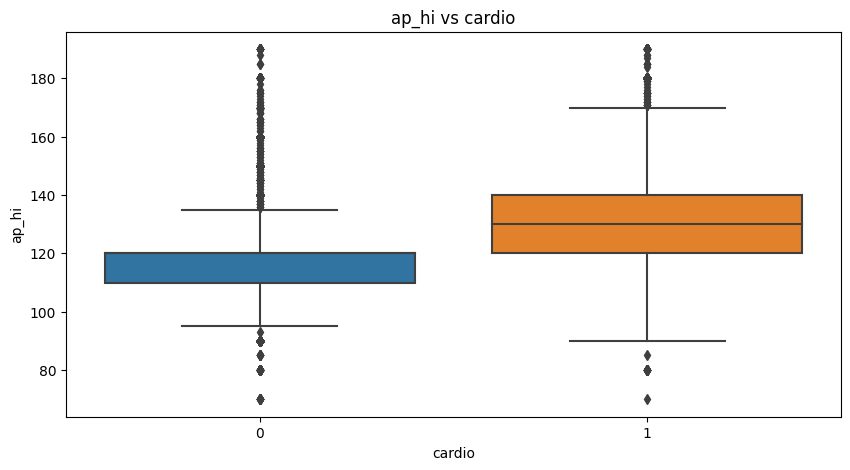

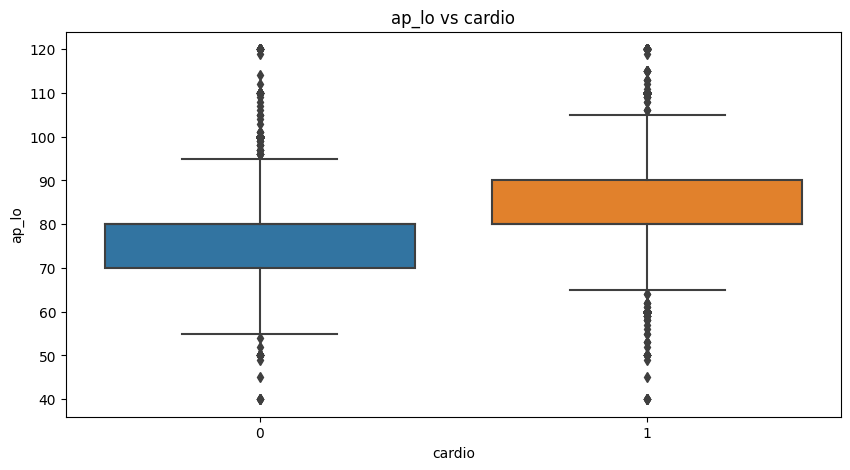

In [17]:
# Plot  new histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


# Plot new boxplots of numerical columns against the target variable
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cardio', y=col, data=data)
    plt.title(f'{col} vs cardio')
    plt.show()

In [18]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000,66705.000000
mean,49958.009789,53.300037,1.354201,164.569687,73.134506,126.194243,81.122899,1.356705,1.220403,0.088839,0.053279,0.804078,0.488959,27.016038
std,28864.285520,6.772576,0.478274,7.790880,12.762491,16.159698,9.249402,0.672692,0.566273,0.284513,0.224592,0.396912,0.499882,4.452142
min,0.000000,39.000000,1.000000,125.000000,40.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.035584
25%,24955.000000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.828125
50%,50001.000000,54.000000,1.000000,165.000000,71.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.196187
75%,74876.000000,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.752744
max,99999.000000,65.000000,2.000000,207.000000,135.000000,190.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,40.000000


In the data cleaning process, we removed certain outliers and observations that were below the first quartile for the 'age' variable. The impact of this cleaning process on the dataset can be observed in the changes to the mean values of several variables.

- Age: The average age saw a minor decrease from 53.3387 years to 53.3000 years. This small change suggests that the removed outliers had ages close to the overall average.
  
- Height: The average height had a slight increase from 164.3592 cm to 164.5697 cm. This change is not significant and suggests that the data cleaning did not heavily impact this variable.
  
- Weight: The average weight decreased from 74.2057 kg to 73.1345 kg. This indicates that some of the removed outliers or observations had weights above the average.
  
- Ap_hi: The average systolic blood pressure ('ap_hi') decreased from 128.8173 to 126.1942. This suggests that the removed observations had higher systolic blood pressure compared to the average.
  
- Ap_lo: The average diastolic blood pressure ('ap_lo') showed a significant decrease from 96.6304 to 81.1229. This large decrease indicates that the removed outliers had considerably higher diastolic blood pressure than the average.
  
- BMI: The average Body Mass Index (BMI) decreased from 27.5565 to 27.0160. This change suggests that some of the removed outliers or observations were above the average BMI.

These changes in the means of the variables provide valuable insights into the characteristics of the outliers and observations that were removed during the data cleaning process.

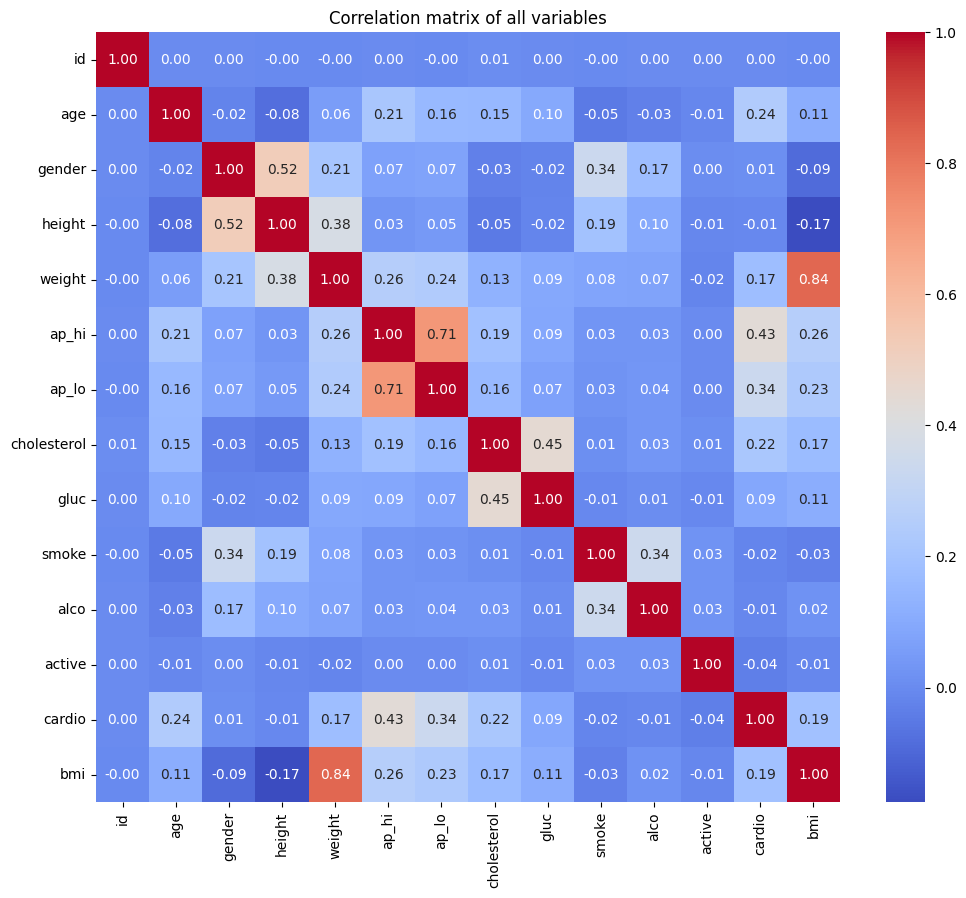

In [19]:
# Calculate correlation matrix
corr = data.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation matrix of all variables')
plt.show()

Now, 

age(0.24), weight(0.17), ap_hi(0.43), ap_lo(0.34),cholesterol(0.22) and bmi (0.19) show a moderate positive correlation with the presence of cardiovascular disease (cardio).
age and cardio: There is a positive correlation coefficient (0.24), indicating that the risk of cardiovascular disease tends to increase with age.
weight and ap_hi/ap_lo: There is a positive correlation between weight and both systolic (0.26) and diastolic (0.24) blood pressure. This suggests that higher weight may be associated with higher blood pressure.
cholesterol and cardio: There is a moderate positive correlation (0.22), suggesting that high cholesterol levels could be a risk factor for cardiovascular disease.
ap_hi and cardio: There is a moderate positive correlation (0.43), indicating that higher systolic blood pressure is associated with a higher risk of cardiovascular disease.
ap_lo and cardio: There is also a moderate positive correlation (0.34), indicating that higher diastolic blood pressure is associated with a higher risk of cardiovascular disease.
BMI and cardio: There is a positive coefficient(0.19),indicating that higher BMI is associated with a higher risk of cardiovascular disease.
Also this corresponds to our hypothesis that age, blood pressure and cholesterol level are indeed the three most influential factors

active lifestyle shows a slight negative correlation with cardio, indicating that active individuals have a slightly lower chance of having cardiovascular disease.


gender doesn't seem to have a significant correlation with cardio.

ap_hi and ap_lo are reasonably correlated with each other, which is expected as they both pertain to blood pressure.

cholesterol and gluc(0.09) are also somewhat correlated. This is not surprising, as these two can be related in terms of diet and lifestyle.

In [20]:
p = data[data['cardio']==0]
n= data[data['cardio']==1]
p

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
5,8,60,1,151,67.0,120,80,2,2,0,0,0,0,29.384676
6,9,61,1,157,93.0,130,80,3,1,0,0,1,0,37.729725
8,13,48,1,158,71.0,110,70,1,1,0,0,1,0,28.440955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69987,99979,52,1,151,49.0,120,80,1,1,0,0,1,0,21.490286
69988,99981,60,1,160,59.0,110,70,1,1,0,0,1,0,23.046875
69991,99988,56,1,159,72.0,130,90,2,2,0,0,1,0,28.479886
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438


# Data Feature Engnieering

After the above, we are going to be building predictive model
1. logistic regression
2. Random forest 
3. XGBoost - gradient boost machine
4. SVC

In [21]:
#build a generic model 
#define all the columns
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi'],
      dtype='object')

In [22]:
data


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


Feature engineering 

determine if someone has high blood pressure or not- normal blood pressure is 120/80 or less - 120 systolic and 80 diastolic

Determine if the patient has high Glucose or not

Determine if the patient has high cholesterol or not

Determine if the person is overweight if BMI is 25.0 and over


In [23]:
#map Glucose and cholesterol to determine high glucose and high cholesterol
map_dic = {1:0,2:1,3:1}
data['high_glu'] = data['gluc'].map(map_dic)
data['high_chol'] = data['cholesterol'].map(map_dic)

In [24]:
#BMI to weight measure 
def over_weight(x):
    if x >= 25:
        return 1
    elif x < 25:
        return 0

#apply function to data 
data['high_bmi'] = data['bmi'].apply(over_weight)
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,high_glu,high_chol,high_bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,0,0,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,0,1,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,0,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,0,0,1
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,0,0,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,0,1,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,1,0,1


In [25]:
#convert systolic (ap_hi) and diastolic (ap_lo) to blood pressure measure (high and low blood pressure)
def high_bp(app_hi, app_lo):
    if app_hi > 120 and app_lo > 80:
        return 1
    else:
        return 0

def low_bp(app_hi, app_lo):
    if app_hi <= 90 and app_lo <= 60:
        return 1
    else:
        return 0

data['high_bp'] = data.apply(lambda x: high_bp(x['ap_hi'], x['ap_lo']),axis=1)
data['low_bp'] = data.apply(lambda x: low_bp(x['ap_hi'], x['ap_lo']), axis=1)

data


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,high_glu,high_chol,high_bmi,high_bp,low_bp
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,0,0,0,0,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,1,1,0
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,0,1,0,0,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,0,1,1,0
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,0,1,1,1,0
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,1,0,1,0,0


In [26]:
#Converting Categorical variable 'gluc' into dummies

dummies_gluc = pd.get_dummies(data.gluc, dtype=int)
dummies_gluc.rename(columns = {1:'gluc_norm', 2:'gluc_ab', 3:'gluc_wab'}, inplace = True)
data = pd.concat([data,dummies_gluc],axis=1)
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,cardio,bmi,high_glu,high_chol,high_bmi,high_bp,low_bp,gluc_norm,gluc_ab,gluc_wab
0,0,50,2,168,62.0,110,80,1,1,0,...,0,21.967120,0,0,0,0,0,1,0,0
1,1,55,1,156,85.0,140,90,3,1,0,...,1,34.927679,0,1,1,1,0,1,0,0
2,2,52,1,165,64.0,130,70,3,1,0,...,1,23.507805,0,1,0,0,0,1,0,0
3,3,48,2,169,82.0,150,100,1,1,0,...,1,28.710479,0,0,1,1,0,1,0,0
4,4,48,1,156,56.0,100,60,1,1,0,...,0,23.011177,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,...,1,29.384757,0,0,1,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,...,0,26.927438,0,0,1,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,...,1,31.353579,0,1,1,1,0,1,0,0
69998,99998,61,1,163,72.0,135,80,1,2,0,...,1,27.099251,1,0,1,0,0,0,1,0


In [27]:
#Converting Categorical variable 'cholesterol' into dummies

dummies_chol = pd.get_dummies(data.cholesterol, dtype=int)
dummies_chol.rename(columns = {1:'chol_norm', 2:'chol_ab', 3:'chol_wab'}, inplace = True)
data = pd.concat([data,dummies_chol],axis=1)
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,high_chol,high_bmi,high_bp,low_bp,gluc_norm,gluc_ab,gluc_wab,chol_norm,chol_ab,chol_wab
0,0,50,2,168,62.0,110,80,1,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1,55,1,156,85.0,140,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
2,2,52,1,165,64.0,130,70,3,1,0,...,1,0,0,0,1,0,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,...,0,1,1,0,1,0,0,1,0,0
4,4,48,1,156,56.0,100,60,1,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,...,0,1,0,0,1,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,...,0,1,0,0,1,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,...,0,1,0,0,0,1,0,1,0,0


Numerical variables: age, height, weight, ap_hi, ap_lo,BMI

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp

###FEATURE ENGINEERING STOPSS HERE


In [28]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab'],
      dtype='object')

In [29]:
log = LogisticRegression()
log.fit(data[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]
, data['cardio'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
pred = log.predict(data[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]
)

 'gluc_norm', 'gluc_ab', 'gluc_wab','ap_hi','ap_lo','high_glu'

In [31]:
print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7262274192339405
0.698038956314693
0.6471670345842532
0.7575909841360994


In [32]:
log_coef=pd.DataFrame([log.feature_names_in_,log.coef_.flatten()]).T
log_coef.sort_values(by = 1,inplace = True)
log_coef

,0,1
14,chol_norm,-0.306089
5,bmi,-0.163226
15,chol_ab,-0.11613
6,high_glu,-0.086293
1,height,-0.062685
13,gluc_wab,-0.056749
12,gluc_ab,-0.029544
8,high_bmi,-0.013436
4,ap_lo,0.000761
0,age,0.051373


According to the logistic regression coefficent, we could pick out the variables that siginificant to the model.

'chol_wab' : Chol well above average
'high_bp'
'high_chol' Those 3 variable is significant to the model.

'weight','low_bp','ap_hi','age' has meduim siginificant to the model include these varibales will increased the accuracy 

'ap_lo' and 'high_bmi' is relatively less significant to the model

'gluc_wab','height','high_glu','bmi','chol_norm'

Next Step I will try to delete the variables that not significant to the model to see if it bring significant change to the model
We want to use as less variables as we could but also keep high accuracy. In this case, our model like SVC could be less time consuming

In [33]:
#Delete 'ap_lo' and 'high_bmi'
variables = data[['age', 'height', 'weight', 'ap_hi',  'bmi',
       'high_glu', 'high_chol', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]

log = LogisticRegression()
log.fit(variables, data['cardio'])

pred = log.predict(variables)

print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7258526347350274
0.6957592293742825
0.6410963944076526
0.7606125641118912


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After delete the 'ap_lo' and 'high_bmi' the accuary score drop 0.004 which is acceptable.

Next Step I will drop some meduim significant variables to see how the model accuray change.

In [57]:
#Delete 'height', 'gluc_ab', 'gluc_wab', 'chol_ab', 'chol_wab','weight','low_bp'
variables = data[['age', 'ap_hi',  'bmi','high_glu', 'high_chol', 'high_bp', 'gluc_norm', 'chol_norm']]

log = LogisticRegression()
log.fit(variables, data['cardio'])

pred = log.predict(variables)

print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7218649276665917
0.6927853488102532
0.6413723325974982
0.7531593159315931


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Variable Deletion Rationale:

1. 'height': they are all medium significant to the data. Form our previous oberservation, we noticed the individauls with higher weight will more likely to have cardiovascular but in the coefficent 'weight' is not significant to the model. In addition, a heavey weight of individaul could due to varios reason like they have more muscle mass or have heavier bone mass. In the dataset, we also have a variable called 'bmi' it is a caculation use weight and height to determine if someone is overweight. So we keep the bmi to represent the 'height' and 'weight'

2. 'gluc_ab' ,'gluec_ab': those two could be represent by ‘high_glu’ because it is combine by the gluc above average and well above average.

3. 'chol_ab', 'chol_wab' could represented by 'high_chol' 

4. 'low_bp' is not significant to the model after delete it the accuracy is increasing

This feature election is mainly for SVC model, since SVC might be the most time consuming model among the models we choose less variable would reduce the modeling time. 

# Model and Test

In [35]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,high_chol,high_bmi,high_bp,low_bp,gluc_norm,gluc_ab,gluc_wab,chol_norm,chol_ab,chol_wab
0,0,50,2,168,62.0,110,80,1,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1,55,1,156,85.0,140,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
2,2,52,1,165,64.0,130,70,3,1,0,...,1,0,0,0,1,0,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,...,0,1,1,0,1,0,0,1,0,0
4,4,48,1,156,56.0,100,60,1,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,...,0,1,0,0,1,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,...,0,1,0,0,1,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,...,0,1,0,0,0,1,0,1,0,0


In [36]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab'],
      dtype='object')

## SVC Model

In [37]:
x = data[['age', 'ap_hi','bmi','high_glu', 'high_chol', 'high_bp', 'gluc_norm', 'chol_norm']]
y = data['cardio']

In [38]:

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [39]:
svc = SVC(kernel='linear')
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [59]:
pred_sv = svc.predict(x_test)
print(accuracy_score(pred_sv,y_test))
print(f1_score(pred_sv,y_test))
print(precision_score(pred_sv,y_test))
print(recall_score(pred_sv,y_test))

0.7239337381005921
0.7075359326610022
0.6794265670276041
0.7380715705765407


0.72 represent a siginificant accuracy of SVC for this binary prediction.

In [41]:
# Now let  find the best params for SVC
params_svc = {
     'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
   }
randomsearch_svc = RandomizedSearchCV(svc, params_svc,n_iter=2 )
randomsearch_svc.fit(x_train,y_train)
best_params = randomsearch_svc.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}


In [55]:
svc = SVC(kernel='rbf',gamma='auto',C=0.1)
svc.fit(x_train, y_train)

SVC(C=0.1, gamma='auto')

In [56]:
pred_sv = svc.predict(x_test)
accuracy_score(pred_sv, y_test)

0.7239337381005921

Because the dataset is too big and I have limited computational power. So I set the n_iter =  6.
It will decrease the accuracy but increase the efficiency. If I set the n_iter = 15 it could run more than 2 hours.

In [42]:
randomsearch_svc.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}

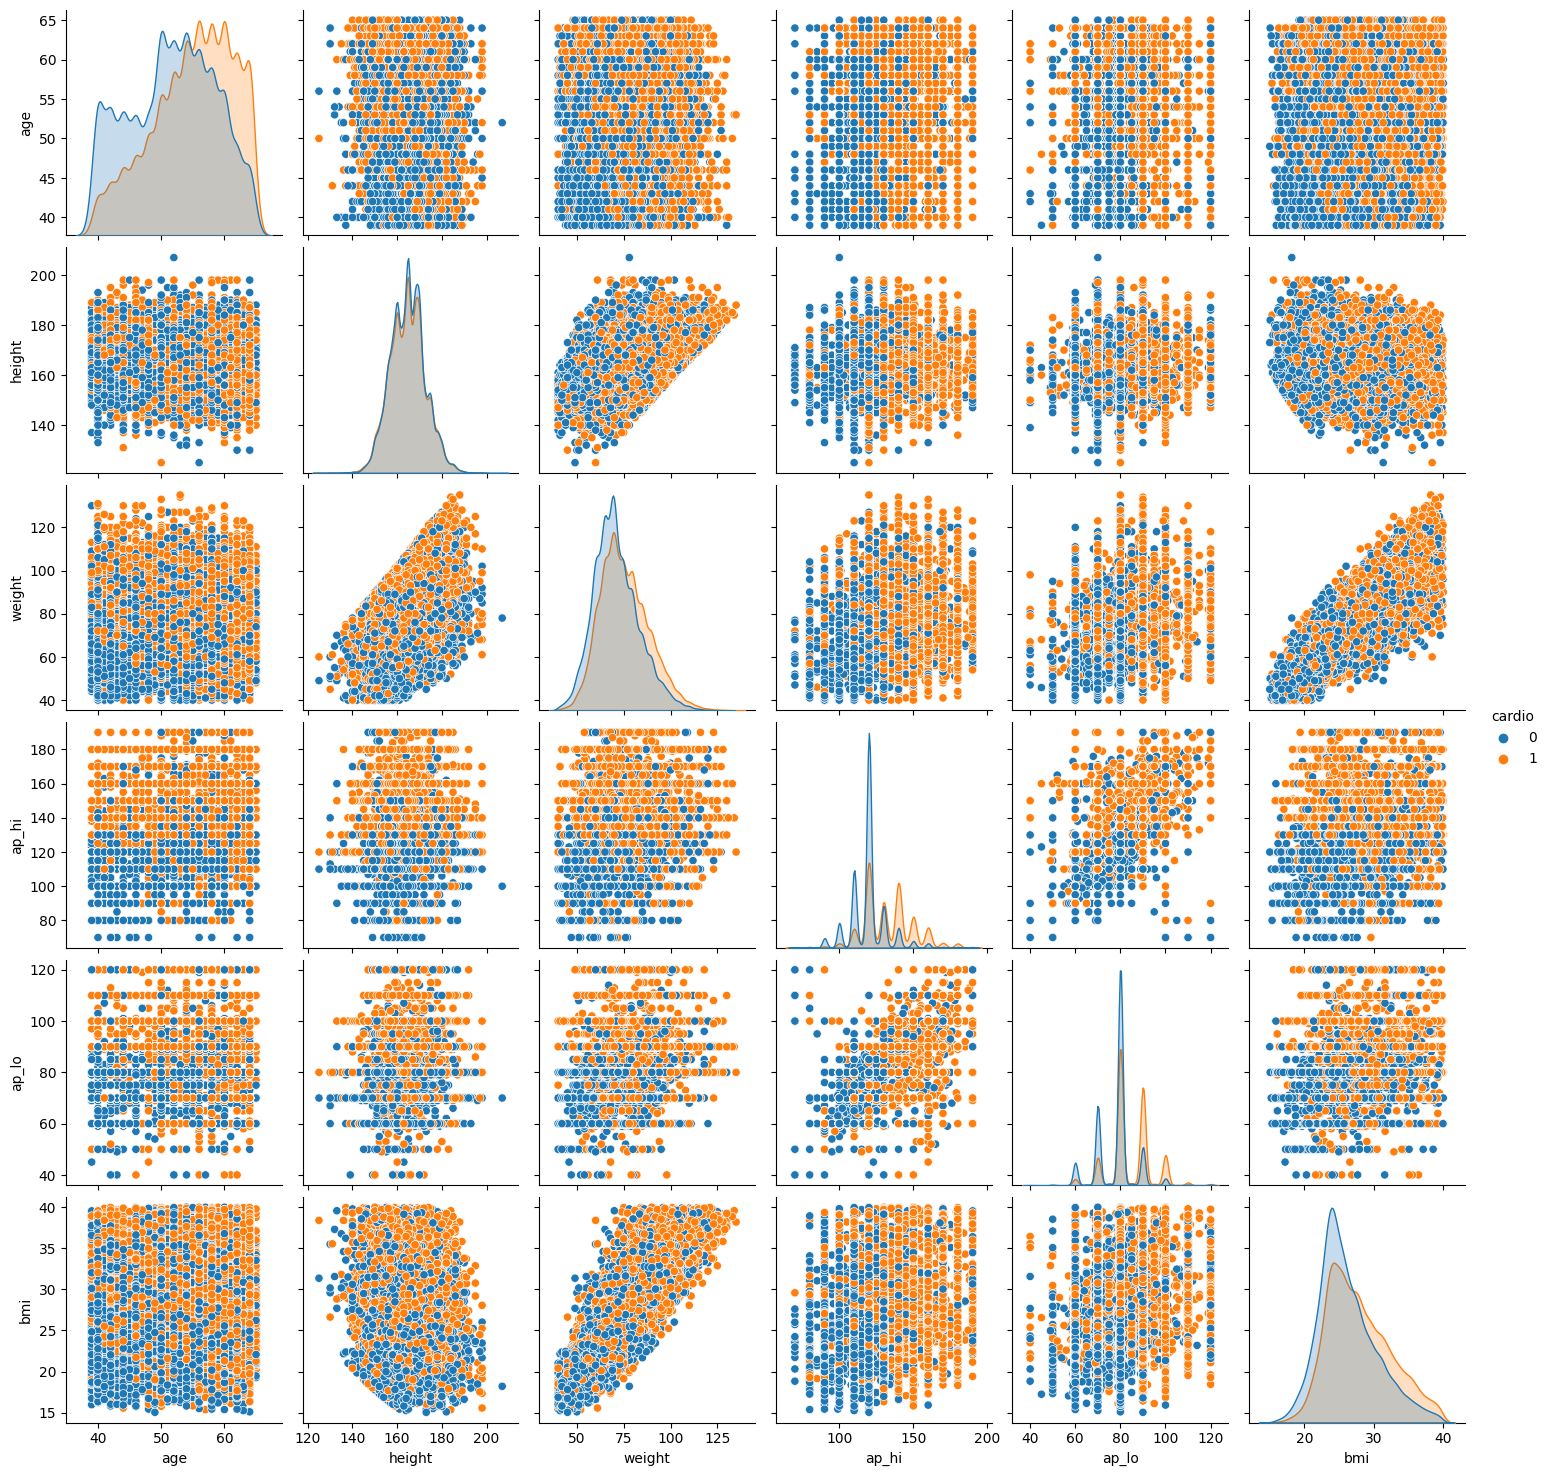

In [43]:
num_col = ['age','height','weight','ap_hi','ap_lo','bmi','cardio']
sns.pairplot(data[num_col],hue='cardio')

From the above it is visible that age,ap_hi,ap_lo, bmi and weight listed in the order of strenght play a major role in determing if a person has cardio-vascula disease or not . height however is not a strong determinant

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp

In [44]:
cardio_gen = data.groupby(['gender','cardio'])[['age']].count().unstack()
cardio_gen['total'] = cardio_gen['age'][0] + cardio_gen['age'][1]
cardio_gen['N_cardio'] = cardio_gen['age'][0]/cardio_gen['total']
cardio_gen['Y_cardio'] = cardio_gen['age'][1]/cardio_gen['total']
cardio_gen

#gender is a relative fair independent variable but not too strong because 48% of people with cardio are men and 49 are women
# it is a balanced view and not a strong determinant of cardio

age         total  N_cardio  Y_cardio
cardio      0      1                           
gender                                         
1       22194  20884  43078  0.515205  0.484795
2       11895  11732  23627  0.503449  0.496551

In [45]:
cardio_smoke = data.groupby(['smoke','cardio'])[['age']].count().unstack()
cardio_smoke['total'] = cardio_smoke['age'][0] + cardio_smoke['age'][1]
cardio_smoke['N_cardio'] = cardio_smoke['age'][0]/cardio_smoke['total']
cardio_smoke['Y_cardio'] = cardio_smoke['age'][1]/cardio_smoke['total']
cardio_smoke
#smoking could be considered as a determinat but not really a strong determinant 

age         total  N_cardio  Y_cardio
cardio      0      1                           
smoke                                          
0       30908  29871  60779  0.508531  0.491469
1        3181   2745   5926  0.536787  0.463213

In [46]:
cardio_smoke['age'][0]

smoke
0    30908
1     3181
Name: 0, dtype: int64

In [47]:
cardio_smoke['age'][1]

smoke
0    29871
1     2745
Name: 1, dtype: int64

In [48]:
#males that smoke how many have cardio
cardio_sg = data.groupby(['gender','smoke','cardio'])[['age']].count().unstack()
cardio_sg['total'] = cardio_sg['age'][0][1] + cardio_sg['age'][0][2]
cardio_sg

age        total
cardio            0      1      
gender smoke                    
1      0      21785  20543   NaN
       1        409    341   NaN
2      0       9123   9328   NaN
       1       2772   2404   NaN

In [49]:
cardio_sg['age'][0][1]

smoke
0    21785
1      409
Name: 0, dtype: int64

In [50]:
cardio_sg['age'][1][2]

smoke
0    9328
1    2404
Name: 1, dtype: int64

In [51]:
#because the data is skewed, I would group by high cholestrol (how many people with high cholesterol have cardio)
# how many percentage with normal cholesterol has cardio
high_chole = data.groupby(['high_chol','cardio'])[['id']].count().unstack()
high_chole['total'] = high_chole['id'][0] + high_chole['id'][1]
high_chole['N_cardio'] = high_chole['id'][0]/high_chole['total']
high_chole['Y_cardio'] = high_chole['id'][1]/high_chole['total']
high_chole
#We can see that high cholesterol has a part to play in cardio as people with 66% of people with high cholesterol have cardio. 
# we can still see that it is not absolutely dependent because 44% of people with cardio have no cholesterol, which is quite a 
# a significant number   

id         total  N_cardio  Y_cardio
cardio         0      1                           
high_chol                                         
0          28652  21698  50350  0.569057  0.430943
1           5437  10918  16355  0.332437  0.667563

In [52]:
cardio_glu = data.groupby(['cardio','high_glu'])[['age']].count().unstack()
cardio_glu['total'] = cardio_glu['age'][0] + cardio_glu['age'][1]
cardio_glu['per_0glu'] = cardio_glu['age'][0]/cardio_glu['total']
cardio_glu['per_highglu'] = cardio_glu['age'][1]/cardio_glu['total']
cardio_glu

age        total  per_0glu per_highglu
high_glu      0     1                             
cardio                                            
0         30161  3928  34089  0.884772    0.115228
1         26806  5810  32616  0.821867    0.178133

In [53]:
cardio_smoke = data.groupby(['cardio','smoke'])[['age']].count().unstack()
cardio_smoke['total'] = cardio_smoke['age'][0] + cardio_smoke['age'][1]
cardio_smoke['per_0smoke'] = cardio_smoke['age'][0]/cardio_smoke['total']
cardio_smoke['per_smoker'] = cardio_smoke['age'][1]/cardio_smoke['total']
cardio_smoke

age        total per_0smoke per_smoker
smoke       0     1                             
cardio                                          
0       30908  3181  34089   0.906685   0.093315
1       29871  2745  32616   0.915839   0.084161

In [54]:
#checking which columns have skewed data
data.groupby('over_weight')['id'].count()

KeyError: 'over_weight'

In [ ]:
data.groupby('active')['id'].count()

active
0    13069
1    53636
Name: id, dtype: int64

In [ ]:
data.groupby('alco')['id'].count()

alco
0    63151
1     3554
Name: id, dtype: int64

In [ ]:
data.groupby('high_bp')['id'].count()

high_bp
0    49333
1    17372
Name: id, dtype: int64

In [ ]:
data.groupby('low_bp')['id'].count()

low_bp
0    65860
1      845
Name: id, dtype: int64

In [ ]:
#define normal bp
def norm_bp(high_bp, low_bp):
    if high_bp == 1:
        return 0
    elif low_bp == 1:
        return 0
    else:
        return 1

data['norm_bp'] = data.apply(lambda x: norm_bp(x['high_bp'],x['low_bp']),axis=1)


In [ ]:
data.groupby('norm_bp')['id'].count()

norm_bp
0    18217
1    48488
Name: id, dtype: int64

In [ ]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp'],
      dtype='object')

From the above it is visible that age,ap_hi,ap_lo, bmi and weight listed in the order of strenght play a major role in determing if a person has cardio-vascula disease or not . height however is not a strong determinant

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp

In [ ]:
#build a dummy model with all variables 
all_model = LogisticRegression()
all_model.fit(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']], data['cardio'])

LogisticRegression()

In [ ]:
all_pred = all_model.predict(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']])

In [ ]:

print('accuracy_score:', accuracy_score(all_pred,data['cardio']))
print('f1_score', f1_score(all_pred,data['cardio']))
print('precision_score:' , precision_score(all_pred,data['cardio']))
print('recall_score:' , recall_score(all_pred,data['cardio']))

accuracy_score: 0.7034255303200659
f1_score 0.6826239712511832
precision_score: 0.6522872209958303
recall_score: 0.7159201803681394


In [ ]:
#dummy random forest 
dum_random_forest = RandomForestClassifier()
dum_random_forest.fit(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']], data['cardio'])


RandomForestClassifier()

In [ ]:
random_forest_pred = dum_random_forest.predict(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']])

In [ ]:
print('Randome Forest accuracy_score:', accuracy_score(random_forest_pred, data['cardio']))
print('Randome Forest  f1_score', f1_score(random_forest_pred, data['cardio']))
print(' Randome Forest precision_score:' , precision_score(random_forest_pred, data['cardio']))
print('Randome Forest  recall_score:' , recall_score(random_forest_pred, data['cardio']))

Randome Forest accuracy_score: 1.0
Randome Forest  f1_score 1.0
 Randome Forest precision_score: 1.0
Randome Forest  recall_score: 1.0


In [ ]:
#dummy xgboost model
dum_xgb = xgb.XGBClassifier()
dum_xgb.fit(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']], data['cardio'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
xgb_pred = dum_xgb.predict(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp', 'norm_bp']])

In [ ]:
print('XGB accuracy_score:', accuracy_score(xgb_pred, data['cardio']))
print('XGB f1_score', f1_score(xgb_pred, data['cardio']))
print(' XGB precision_score:' , precision_score(xgb_pred, data['cardio']))
print('XGB recall_score:' , recall_score(xgb_pred, data['cardio']))

XGB accuracy_score: 0.7657746795592534
XGB f1_score 0.748664822083521
 XGB precision_score: 0.7134535197449104
XGB recall_score: 0.787532151076215


In [ ]:
#let fine tune our models
#print out the coeffients for logistic regression
pd.DataFrame([all_model.feature_names_in_,all_model.coef_.flatten()]).T

,0,1
0,id,-0.000001
1,age,0.050344
2,gender,0.002005
3,height,-0.065069
4,weight,0.029606
5,ap_hi,0.054271
6,ap_lo,-0.002338
7,cholesterol,0.010243
8,gluc,0.002012
9,smoke,-0.000108


In [ ]:
#numerical age,ap_hi,ap_lo, bmi and weight 
#categorical 

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp